In [1]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #指定使用編號GPU，預設是0
cfg = tf.compat.v1.ConfigProto() 
cfg.gpu_options.per_process_gpu_memory_fraction = 0.5 # 使用50%的GPU暫存  
session = tf.compat.v1.Session(config=cfg)

Using TensorFlow backend.


In [2]:
def read_img(folder_name):
    array_of_img, array_of_filename = [], [] # this if for store all of the image data
    # this loop is for read each image in this foder,directory_name is the foder name with images.
    for filename in os.listdir(r"./"+folder_name):
        #print(filename) #just for test
        #img is used to store the image data 
        img = cv2.imread(folder_name + "/" + filename)
        new_img = cv2.resize(img, dsize=(64, 64))
        array_of_img.append(new_img)
        #print(img)
    return array_of_img

In [3]:
train_dir = "data/Final exam competition/image_data/train"
path = os.path.join(train_dir)
label = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
img_train, label_train = [], []
for classname in label:
    img_class = read_img(train_dir + "/" + classname)
    for i in range(len(img_class)):
        img_train.append(img_class[i])
        label_train.append(classname)

In [4]:
batch_size = 32 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 5 # 類別的數量
epochs = 50 # 訓練的 epochs 數量

In [5]:
img_train = np.array(img_train)
label_train = np.array(label_train)

#Normalize data
img_train = img_train/255.0

In [6]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
label_train = labelencoder.fit_transform(label_train)
label_train

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [7]:
from sklearn.utils import shuffle
img_train, label_train = shuffle(img_train, label_train) # loop 結束後，將資料順序打亂再重新循環

from keras.preprocessing.image import ImageDataGenerator
#建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(img_train, label_train, test_size=0.1, random_state=4)

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        1

Epoch 1/50
79/79 [==============================] - 8s 96ms/step - loss: 1.4709 - accuracy: 0.3301 - val_loss: 1.4125 - val_accuracy: 0.3569
Epoch 2/50
79/79 [==============================] - 6s 76ms/step - loss: 1.3416 - accuracy: 0.3939 - val_loss: 1.3779 - val_accuracy: 0.3852
Epoch 3/50
79/79 [==============================] - 5s 68ms/step - loss: 1.2968 - accuracy: 0.4095 - val_loss: 1.2979 - val_accuracy: 0.4240
Epoch 4/50
79/79 [==============================] - 6s 72ms/step - loss: 1.2452 - accuracy: 0.4470 - val_loss: 1.1884 - val_accuracy: 0.5194
Epoch 5/50
79/79 [==============================] - 6s 70ms/step - loss: 1.1866 - accuracy: 0.4976 - val_loss: 1.2203 - val_accuracy: 0.4982
Epoch 6/50
79/79 [==============================] - 5s 69ms/step - loss: 1.1476 - accuracy: 0.5203 - val_loss: 1.1371 - val_accuracy: 0.5406
Epoch 7/50
79/79 [==============================] - 6s 72ms/step - loss: 1.1200 - accuracy: 0.5231 - val_loss: 1.0759 - val_accuracy: 0.6042
Epoch 8/50
79

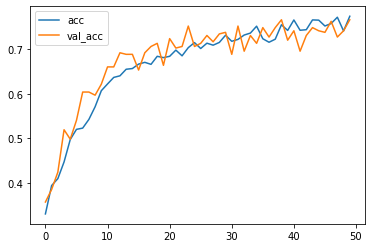

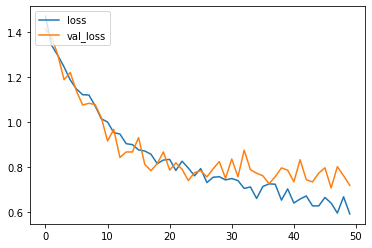

In [10]:
history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)/batch_size),  # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_valid, y_valid))
score = model.evaluate(x_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(loc=2)
plt.show()
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc=2)
plt.show()

In [13]:
test_dir = "data/Final exam competition/image_data/test"
path = os.path.join(test_dir)
img_test = read_img(test_dir)

img_test = np.array(img_test)
x_test = img_test/255.0
y_prediction = model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis = 1)

In [14]:
array_of_filename = [] # this if for store all of the image data
# this loop is for read each image in this foder,directory_name is the foder name with images.
for filename in os.listdir(r"./data/Final exam competition/image_data/test"): 
    array_of_filename.append(filename.split(".")[0])

In [15]:
#submit
submit = pd.DataFrame(columns = ['id', 'flower_class'])
submit['id'] = pd.DataFrame(array_of_filename)[0]
submit['flower_class'] = pd.DataFrame(y_prediction)[0]
print(submit)
submit.to_csv('submit_final.csv', index= False)

                                    id  flower_class
0     0028624c49b3e0610ff9f1d111f5d532             2
1     002c30700185b7971369258b438070d5             4
2     00852f4f666acecd0c0d140365b42efd             4
3     00c08828fce04e360c732cac01edad9e             4
4     00d366e7877b6a78b104b57d67b60e6b             2
...                                ...           ...
1995  ff7eac29b6d7a33fbd8009677c3e9c58             1
1996  ffbc32a7b67dfe72b8d35d4b1b35fd6c             1
1997  ffea1f275c05accb0a6bfd1203620c7e             0
1998  ffeb2a1cf53464b6af937ab8af0c2946             3
1999  ffefcc68e2e7eed8b17b0b5b0f740538             4

[2000 rows x 2 columns]


In [11]:
# 顯示圖片
cv2.imshow('train_2', x_train[2])
cv2.waitKey(0)
cv2.destroyAllWindows()